## Object selectivity
This code defines object selectivity based on beta coefficients in multiple linear regression model. Specifically, object selectivity to visual or auditory modality is defined by the differences in beta coefficients within a modality (i.e., Boy image vs. Egg image for visual).

In [69]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

from scipy import stats
from scipy.ndimage import gaussian_filter

import matplotlib as mpl
import matplotlib.pyplot as plt  
from matplotlib_venn import venn2, venn2_circles

from datetime import date
import time

from joblib import Parallel, delayed

import h5py

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
mother_path = Path('D:/Multi-modal project/')

### Parameter setting

In [4]:
gauss_sigma = 2

# colors for multimodal, vis-only, aud-only conditions
color = ['mediumorchid','cornflowerblue','lightcoral','gray']
color2 = ['cyan','magenta','gray']
linestyle = ['-',':']

today = str(date.today())

### Data preparation

In [5]:
save_path = mother_path /'analysis'/'result'/'4.1 Object selectivity'/today
cell_path = mother_path/'analysis'/'result'/'zFR export'/'13-Apr-2022 (5 trials)'
data_path = mother_path /'analysis'/'result'/'4. Object selectivity'/'2023-05-15-1'

cell_list = os.listdir(cell_path)

# load hdf5 files containing shuffled results
f = h5py.File(data_path/'2023-05-15_object_selectivity_result.hdf5','r')

In [67]:
# hdf5 attribute to dataframe
keys = list(f.keys())
attributes = {}

for key in keys:
    attributes[key] = dict(f[key].attrs.items())
    
df = pd.DataFrame.from_dict(attributes, orient='index')
df.index.name = 'key'
df = df.reset_index()

### Cell categorization

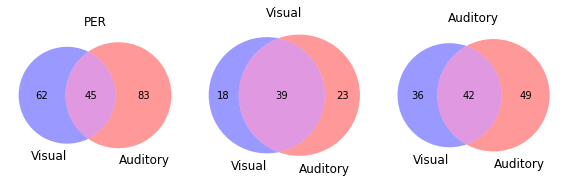

In [98]:
fig,ax = plt.subplots(1,3,figsize=(8,15))

region = ['PER','Visual','Auditory']
for i, r in enumerate(region):
    venn2(subsets = (df[df['Region']==r].groupby('Category').size()['visual'],
                     df[df['Region']==r].groupby('Category').size()['auditory'],
                     df[df['Region']==r].groupby('Category').size()['multimodal']),
          set_labels = ('Visual','Auditory'),set_colors = ('blue','red'),ax=ax[i])
    ax[i].set_title(r)
plt.tight_layout()

### Population coefficient matrix

In [235]:
def plot_population_coef(ax,region,category,modality,only_sig):
    coef_all = np.empty((0,95))
    coef_peak = []
    
    for key in f.keys():
        this_region = f[key].attrs['Region']
        this_cat = f[key].attrs['Category']
    
        if this_region!=region or this_cat!=category:
            continue
        
        coef = np.array(f[f'{key}/{modality}_coef'])
        peak = np.array(f[f'{key}/{modality}_peak'])
    
        if coef[peak]<0:
            coef = coef*-1    
        
        # min-max scaling
        coef_min, coef_max = np.min(coef), np.max(coef)
        coef = (coef-coef_min)/(coef_max-coef_min)
        
        if only_sig:
            sig_bin = np.array(f[f'{key}/{modality}_bin'])
            coef = [0 if i not in sig_bin else coef[i] for i in range(95)]
                    
        coef_all = np.append(coef_all, [coef], axis=0)
        coef_peak.append(peak.item())
    
    coef_sorted = coef_all[np.argsort(coef_peak),:]
    
    ax.pcolor(coef_sorted,cmap='binary')
    ax.set_xticks([0,40,95])
    ax.set_xticklabels([0,400,950])
    ax.set_xlabel('Time (ms)',fontsize=13)
    ax.set_ylabel('Cell #',fontsize=13)
    ax.set_title(f'{region} {category} cells ({modality})',fontsize=13)

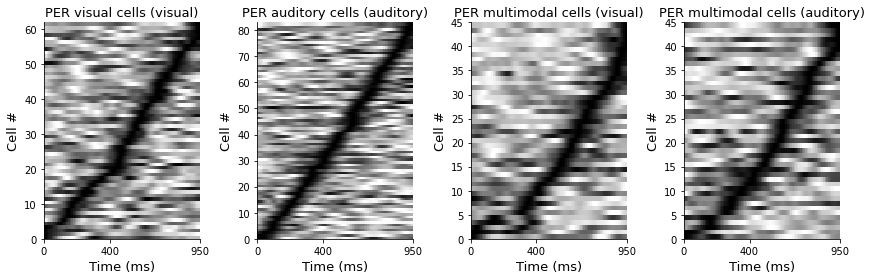

In [243]:
target_region = 'PER'
fig,ax = plt.subplots(1,4,figsize=(12,4))

category = ['visual','auditory','multimodal','multimodal']
modality = ['visual','auditory','visual','auditory']
for i in range(4):
    plot_population_coef(ax[i],target_region,category[i],modality[i],0)
plt.tight_layout()

In [189]:
visual = np.empty((0,95))
visual_peak = []
for key in f.keys():
    region = f[key].attrs['Region']
    cat = f[key].attrs['Category']
    
    if region!='PER' or cat!='visual':
        continue
    
    visual_coef = np.array(f[f'{key}/visual_coef'])
    peak = np.array(f[f'{key}/visual_peak'])
    
    if visual_coef[peak]<0:
        visual_coef = visual_coef*-1
    
    visual = np.append(visual,[visual_coef],axis=0)
    visual_peak.append(peak.item())

visual_sorted = visual[np.argsort(visual_peak),:]

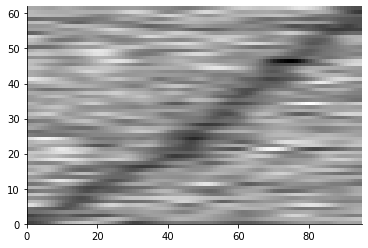

In [175]:
plt.pcolor(visual_sorted,cmap='binary')

In [9]:
def consecutive_bin(sig_bin,cons_bin_crit):
    diff = np.diff(sig_bin)
    array_split = np.split(sig_bin,np.where(diff!=1)[0]+1)
    filtered = [a for a in array_split if len(a)>=cons_bin_crit]
    if len(filtered)!=0:
        result = np.concatenate(filtered)    
    else:
        result = np.array([])
    return result

In [10]:
def plot_SDF_beta(df,linewidth,smooth,save,save_format):
    """
    This function plots mean firing rate patterns of each stimulus condition
    and beta coefficients for visual and auditory terms in multiple linear regression.
    """
    cond = [(df.Type=='Multimodal')&(df.RWD_Loc==boy_goal),
            (df.Type=='Multimodal')&(df.RWD_Loc==egg_goal),
            (df.Type=='Visual')&(df.RWD_Loc==boy_goal),
            (df.Type=='Visual')&(df.RWD_Loc==egg_goal),
            (df.Type=='Auditory')&(df.RWD_Loc==boy_goal),
            (df.Type=='Auditory')&(df.RWD_Loc==egg_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==boy_goal),
            (df.Type=='Elemental')&(df.RWD_Loc==egg_goal)]
    
    cell_full_name = cell_name.strip('.csv')
    
    fr_mean = np.zeros((len(cond),95))
    fr_sem = np.zeros((len(cond),95))
    for i in range(len(cond)):
        fr_mean[i,:] = df[cond[i]].iloc[:,fr_id:fr_id+95].to_numpy().mean(axis=0)
        fr_sem[i,:] = stats.sem(df[cond[i]].iloc[:,fr_id:fr_id+95].to_numpy())
    
    if smooth:
        for i in range(len(cond)):
            fr_mean[i,:] = gaussian_filter(fr_mean[i,:],sigma=gauss_sigma)
            fr_sem[i,:] = gaussian_filter(fr_sem[i,:],sigma=gauss_sigma)
            
    y_max = np.ceil(np.max(fr_mean+fr_sem))
    y_min = np.ceil(np.abs(np.min(fr_mean-fr_sem)))*-1
    
    fig,ax = plt.subplots(3,3,figsize=(15,10))
    plt.suptitle(cell_full_name,fontsize=15);
    x = np.arange(95)*10
    
    for i in range(len(cond)-2):
        if i%2==0:
            ls = linestyle[0]
        else:
            ls = linestyle[1]            
        ax[0,0].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
        ax[0,0].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
        
        ax[i%2+1,0].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
        ax[i%2+1,0].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
        
        if i<6:
            ax[int(np.floor(i/2)),1].plot(x,fr_mean[i,:],color=color[int(np.floor(i/2))],linewidth=linewidth,linestyle=ls)
            ax[int(np.floor(i/2)),1].fill_between(x,fr_mean[i,:]-fr_sem[i,:],fr_mean[i,:]+fr_sem[i,:],color=color[int(np.floor(i/2))],alpha=0.2)
    
    # control stimulus SDF
    #for i in range(3):
    #    ax[i,1].plot(x,fr_mean[6,:],color=color[3])
    #    ax[i,1].plot(x,fr_mean[7,:],color=color[3],linestyle=':')
    
    # SDF for each condition
    t1 = ['All conditions','Boy condition','Egg condition','Multimodal','Visual-only','Auditory-only']
    for i in range(6):
        ax[i%3,int(np.floor(i/3))].scatter(visual_bin*10,np.tile(y_max-0.1,(len(visual_bin),1)),
                                           color=color2[0],marker='*',s=5)
        ax[i%3,int(np.floor(i/3))].scatter(auditory_bin*10,np.tile(y_max-0.3,(len(auditory_bin),1)),
                                           color=color2[1],marker='*',s=5)
        ax[i%3,int(np.floor(i/3))].set_title(t1[i],fontsize=13)
        ax[i%3,int(np.floor(i/3))].set_yticks(np.arange(y_min,y_max+0.1,1))
        ax[i%3,int(np.floor(i/3))].set_ylabel('z-scored FR',fontsize=13)
        ax[i%3,int(np.floor(i/3))].set_xlabel('Time (ms)',fontsize=13)  
        ax[i%3,int(np.floor(i/3))].set_xticks([0,400,950])
        ax[i%3,int(np.floor(i/3))].set_xlim([0,950])    
    
    if smooth:
        for i in range(len(beta_coef)):
            beta_coef[i,:] = gaussian_filter(beta_coef[i,:],sigma=gauss_sigma)
    
    beta_max = np.ceil(np.max(beta_coef))
    beta_min = np.ceil(np.abs(np.min(beta_coef)))*-1
    
    # beta coefficient plot
    t2 = ['Visual term','Auditory term','Interaction term']
    ax[0,2].scatter(visual_bin*10,np.tile(beta_max-0.1,(len(visual_bin),1)),color=color2[0],marker='*',s=5)
    ax[1,2].scatter(auditory_bin*10,np.tile(beta_max-0.1,(len(auditory_bin),1)),color=color2[1],marker='*',s=5)    
    for i in range(3):
        ax[i,2].plot(x,beta_coef[i,:],color=color2[i],linestyle='-',linewidth=linewidth)
        ax[i,2].plot(x,beta_coef[i+3,:],color=color2[i],linestyle=':',linewidth=linewidth)    
            
        ax[i,2].set_title(t2[i],fontsize=13)
        ax[i,2].set_yticks(np.arange(beta_min,beta_max+0.1,0.5))    
        ax[i,2].set_ylabel('Beta coefficient',fontsize=13)
        ax[i,2].set_xlabel('Time (ms)',fontsize=13)    
        ax[i,2].set_xticks([0,400,950])
        ax[i,2].set_xlim([0,950])
        
    plt.tight_layout()
    
    if save:
        fig_path = save_path / region / cat
        os.makedirs(fig_path, exist_ok=True)

        if save_format == 'png':
            plt.savefig(fig_path / f'{cell_full_name}.png', dpi=100, facecolor='white')
        elif save_format == 'svg':
            plt.savefig(fig_path / f'{cell_full_name}.svg')
        plt.close()

In [11]:
def save_result(f):
    """
    This function saves regression results into HDF5 format.
    """
    cell_group = f.create_group(str(cell_id))
    
    cell_group.create_dataset('visual_coef',data=visual)
    cell_group.create_dataset('auditory_coef',data=auditory)   
    cell_group.create_dataset('visual_crit',data=visual_crit)
    cell_group.create_dataset('auditory_crit',data=auditory_crit)
    cell_group.create_dataset('visual_bin',data=visual_bin)
    cell_group.create_dataset('auditory_bin',data=auditory_bin)
    cell_group.create_dataset('visual_peak',data=visual_peak)
    cell_group.create_dataset('auditory_peak',data=auditory_peak)
    
    cell_group.attrs['Rat'] = rat_id
    cell_group.attrs['Region'] = region
    cell_group.attrs['Session'] = session_id
    cell_group.attrs['Category'] = cat

In [12]:
%%time
for cell_run,cell_name in enumerate(cell_list):
    loop_start = time.time()
    # get information about the cell
    cell_info = cell_name.split('-')
    cell_id, rat_id, session_id, region = int(cell_info[0]), cell_info[1], cell_info[2], cell_info[5]
    
    # skip response-selective cell
    if f[str(cell_id)].attrs['Response cell'] == 1:
        continue
    
    # load cell data
    df = pd.read_csv(cell_path/cell_name)
    df.drop(df[df.Correctness==0].index,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df[['Visual','Auditory']] = df[['Visual','Auditory']].fillna('no')
    
    boy_goal = df.loc[df['Visual']=='Boy','RWD_Loc'].values[0]
    boy_aud = df.loc[df['RWD_Loc']==boy_goal,'Auditory'].values[0]
    
    egg_goal = df.loc[df['Visual']=='Egg','RWD_Loc'].values[0]
    egg_aud = df.loc[df['RWD_Loc']==egg_goal,'Auditory'].values[0]
    
    fr_id = df.columns.get_loc('Var10')  # get the index of the first firing rate column
    
    # load beta coefficient
    beta_coef = np.array(f[f'{cell_id}/basic/beta_coef'])
    beta_coef_shuffle = np.array(f[f'{cell_id}/basic_shuffle/beta_coef'])
    
    # define significant selectivity based on shuffled distribution
    visual = np.subtract(beta_coef[0,:],beta_coef[3,:])
    auditory = np.subtract(beta_coef[1,:],beta_coef[4,:])
    
    visual_shuffle = np.subtract(beta_coef_shuffle[:,0,:],beta_coef_shuffle[:,3,:])
    auditory_shuffle = np.subtract(beta_coef_shuffle[:,1,:],beta_coef_shuffle[:,4,:])    
    
    visual_crit = [np.percentile(np.ravel(visual_shuffle),alpha*50), np.percentile(np.ravel(visual_shuffle),100-alpha*50)]
    auditory_crit = [np.percentile(np.ravel(auditory_shuffle),alpha*50), np.percentile(np.ravel(auditory_shuffle),100-alpha*50)]

    visual_bin = np.where((visual<visual_crit[0])|(visual>visual_crit[1]))[0]
    auditory_bin = np.where((auditory<auditory_crit[0])|(auditory>auditory_crit[1]))[0]

    visual_bin = consecutive_bin(visual_bin,cons_bin_crit)
    auditory_bin = consecutive_bin(auditory_bin,cons_bin_crit)
    
    # find bin with maximum selectivity
    visual_peak = visual_bin[np.argmax(np.abs(beta_coef[0, visual_bin] - beta_coef[3, visual_bin]))] if len(visual_bin) != 0 else []
    auditory_peak = auditory_bin[np.argmax(np.abs(beta_coef[1, auditory_bin] - beta_coef[4, auditory_bin]))] if len(auditory_bin) != 0 else []
    
    # categorize a neuron based on coding modality
    if len(visual_bin) != 0 and len(auditory_bin) != 0:
        cat = 'multimodal'
    elif len(visual_bin) != 0:
        cat = 'visual'
    elif len(auditory_bin) != 0:
        cat = 'auditory'
    else:
        cat = 'none'         
        
    # plot SDF and beta coefficient + mark bins with significant selectivity    
    plot_SDF_beta(df,2,1,1,'png')
    
    # save results into HDF5 format
    save_result(s)    
                
    loop_end = time.time()
    loop_time = divmod(loop_end-loop_start,60)
    print(cell_name.strip('.csv'), f'////// {cell_run+1}/{len(cell_list)} completed  //////  {int(loop_time[0])} min {loop_time[1]:.2f} sec')

0003-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.1 ////// 1/878 completed  //////  0 min 0.91 sec
0004-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.2 ////// 2/878 completed  //////  0 min 0.88 sec
0005-600-1-1-Crossmodal-TeV-deep-(-7.32 mm)-TT4.3 ////// 3/878 completed  //////  0 min 0.89 sec
0006-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.1 ////// 4/878 completed  //////  0 min 0.87 sec
0007-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.2 ////// 5/878 completed  //////  0 min 0.88 sec
0008-600-1-1-Crossmodal-PER-superficial-(-7.2 mm)-TT5.3 ////// 6/878 completed  //////  0 min 1.39 sec
0010-600-1-1-Crossmodal-TeV-deep-(-6.96 mm)-TT6.2 ////// 7/878 completed  //////  0 min 0.80 sec
0011-600-1-1-Crossmodal-PER-superficial-(-6.48 mm)-TT7.1 ////// 8/878 completed  //////  0 min 0.89 sec
0013-600-1-1-Crossmodal-PER-deep-(-6.48 mm)-TT8.2 ////// 9/878 completed  //////  0 min 0.76 sec
0014-600-1-1-Crossmodal-PER-deep-(-6.48 mm)-TT8.3 ////// 10/878 completed  //////  0 min 0.77 sec
0015

0176-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.11 ////// 88/878 completed  //////  0 min 0.79 sec
0177-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.2 ////// 89/878 completed  //////  0 min 1.64 sec
0178-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.3 ////// 90/878 completed  //////  0 min 0.74 sec
0179-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.4 ////// 91/878 completed  //////  0 min 0.70 sec
0181-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.6 ////// 92/878 completed  //////  0 min 0.86 sec
0182-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.7 ////// 93/878 completed  //////  0 min 0.71 sec
0183-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.8 ////// 94/878 completed  //////  0 min 0.80 sec
0184-602-1-1-Crossmodal-PER-deep-(-5.28 mm)-TT6.9 ////// 95/878 completed  //////  0 min 0.77 sec
0185-602-1-1-Crossmodal-PER-deep-(-4.8 mm)-TT7.1 ////// 96/878 completed  //////  0 min 0.79 sec
0188-602-1-1-Crossmodal-TeV-deep-(-4.44 mm)-TT9.2 ////// 97/878 completed  //////  0 min 0.83 sec
0190-602-1-1-Crossmo

0299-602-3-3-Crossmodal-Auditory-superficial-(-5.52 mm)-TT19.5 ////// 173/878 completed  //////  0 min 0.78 sec
0304-602-3-3-Crossmodal-TeV-superficial-(-5.64 mm)-TT21.4 ////// 174/878 completed  //////  0 min 0.69 sec
0307-602-3-3-Crossmodal-PER-superficial-(-5.4 mm)-TT22.2 ////// 175/878 completed  //////  0 min 2.57 sec
0308-602-3-3-Crossmodal-PER-superficial-(-5.4 mm)-TT22.3 ////// 176/878 completed  //////  0 min 0.84 sec
0309-602-3-3-Crossmodal-PER-superficial-(-5.4 mm)-TT22.4 ////// 177/878 completed  //////  0 min 0.75 sec
0311-602-4-4-Crossmodal-PER-superficial-(-5.28 mm)-TT6.1 ////// 178/878 completed  //////  0 min 0.77 sec
0312-602-4-4-Crossmodal-PER-superficial-(-5.28 mm)-TT6.2 ////// 179/878 completed  //////  0 min 0.84 sec
0313-602-4-4-Crossmodal-PER-superficial-(-5.28 mm)-TT6.3 ////// 180/878 completed  //////  0 min 0.76 sec
0314-602-4-4-Crossmodal-PER-deep-(-4.8 mm)-TT7.1 ////// 181/878 completed  //////  0 min 0.73 sec
0315-602-4-4-Crossmodal-PER-deep-(-4.8 mm)-TT7.

1050-640-3-3-Crossmodal-PER-deep-(-5.52 mm)-TT5.1 ////// 264/878 completed  //////  0 min 0.80 sec
1051-640-3-3-Crossmodal-PER-deep-(-4.8 mm)-TT10.1 ////// 265/878 completed  //////  0 min 0.82 sec
1052-640-3-3-Crossmodal-PER-deep-(-4.8 mm)-TT10.2 ////// 266/878 completed  //////  0 min 0.85 sec
1056-640-3-3-Crossmodal-PER-deep-(-4.56 mm)-TT11.2 ////// 270/878 completed  //////  0 min 0.79 sec
1057-640-3-3-Crossmodal-PER-deep-(-4.56 mm)-TT11.3 ////// 271/878 completed  //////  0 min 0.77 sec
1058-640-3-3-Crossmodal-PER-superficial-(-4.56 mm)-TT13.1 ////// 272/878 completed  //////  0 min 0.82 sec
1059-640-3-3-Crossmodal-PER-superficial-(-4.56 mm)-TT13.2 ////// 273/878 completed  //////  0 min 0.72 sec
1062-640-3-3-Crossmodal-PER-superficial-(-4.56 mm)-TT15.2 ////// 275/878 completed  //////  0 min 0.73 sec
1063-640-3-3-Crossmodal-PER-superficial-(-4.56 mm)-TT15.3 ////// 276/878 completed  //////  0 min 0.72 sec
1067-640-3-3-Crossmodal-TeV-deep-(-5.88 mm)-TT22.1 ////// 277/878 completed

1385-647-6-6-Crossmodal-PER-deep-(-5.4 mm)-TT9.3 ////// 356/878 completed  //////  0 min 0.74 sec
1391-647-6-6-Crossmodal-PER-deep-(-5.2 mm)-TT15.4 ////// 357/878 completed  //////  0 min 0.83 sec
1392-647-6-6-Crossmodal-PER-deep-(-5.2 mm)-TT15.5 ////// 358/878 completed  //////  0 min 0.76 sec
1394-647-6-6-Crossmodal-TeV-superficial-(-5.52 mm)-TT16.2 ////// 360/878 completed  //////  0 min 0.75 sec
1395-647-6-6-Crossmodal-TeV-superficial-(-5.52 mm)-TT16.3 ////// 361/878 completed  //////  0 min 0.73 sec
1396-647-6-6-Crossmodal-TeV-superficial-(-5.52 mm)-TT16.4 ////// 362/878 completed  //////  0 min 0.73 sec
1399-647-6-6-Crossmodal-PER-superficial-(-5.88 mm)-TT19.1 ////// 363/878 completed  //////  0 min 0.76 sec
1401-647-6-6-Crossmodal-PER-superficial-(-5.88 mm)-TT19.3 ////// 364/878 completed  //////  0 min 0.86 sec
1404-647-6-6-Crossmodal-PER-superficial-(-6.24 mm)-TT20.3 ////// 365/878 completed  //////  0 min 0.74 sec
1406-647-6-6-Crossmodal-TeV-deep-(-6.12 mm)-TT21.2 ////// 366/

1651-654-5-5-Crossmodal-Auditory-deep-(-4.8 mm)-TT14.1 ////// 458/878 completed  //////  0 min 0.80 sec
1653-654-5-5-Crossmodal-Auditory-deep-(-5.2 mm)-TT16.2 ////// 460/878 completed  //////  0 min 0.73 sec
1654-654-5-5-Crossmodal-Auditory-deep-(-5.2 mm)-TT16.3 ////// 461/878 completed  //////  0 min 0.76 sec
1655-654-5-5-Crossmodal-Tev-deep-(-5.88 mm)-TT18.1 ////// 462/878 completed  //////  0 min 0.78 sec
1656-654-5-5-Crossmodal-Tev-deep-(-5.88 mm)-TT18.2 ////// 463/878 completed  //////  0 min 0.82 sec
1657-654-5-5-Crossmodal-TeV-deep-(-6.12 mm)-TT21.1 ////// 464/878 completed  //////  0 min 0.91 sec
1659-654-5-5-Crossmodal-TeV-deep-(-6.12 mm)-TT21.3 ////// 465/878 completed  //////  0 min 1.30 sec
1660-654-5-5-Crossmodal-TeV-deep-(-6.12 mm)-TT21.4 ////// 466/878 completed  //////  0 min 0.85 sec
1661-654-5-5-Crossmodal-TeV-deep-(-6.12 mm)-TT21.5 ////// 467/878 completed  //////  0 min 0.97 sec
1662-654-5-5-Crossmodal-Tev-superficial-(-6.6 mm)-TT23.1 ////// 468/878 completed  /////

1850-679-2-2-Crossmodal-Auditory-deep-(-5.64 mm)-TT21.2 ////// 555/878 completed  //////  0 min 1.04 sec
1851-679-2-2-Crossmodal-Auditory-deep-(-5.64 mm)-TT21.3 ////// 556/878 completed  //////  0 min 0.93 sec
1854-679-2-2-Crossmodal-Auditory-deep-(-5.64 mm)-TT21.6 ////// 557/878 completed  //////  0 min 0.80 sec
1857-679-3-3-Crossmodal-Visual-deep-(-6.36 mm)-TT1.1 ////// 559/878 completed  //////  0 min 0.99 sec
1858-679-3-3-Crossmodal-Visual-deep-(-6.24 mm)-TT2.1 ////// 560/878 completed  //////  0 min 0.83 sec
1859-679-3-3-Crossmodal-Visual-deep-(-6.24 mm)-TT2.2 ////// 561/878 completed  //////  0 min 0.88 sec
1861-679-3-3-Crossmodal-Visual-deep-(-4.56 mm)-TT11.1 ////// 563/878 completed  //////  0 min 0.86 sec
1862-679-3-3-Crossmodal-PER-deep-(-4.8 mm)-TT12.1 ////// 564/878 completed  //////  0 min 0.80 sec
1863-679-3-3-Crossmodal-PER-deep-(-4.8 mm)-TT12.2 ////// 565/878 completed  //////  0 min 0.71 sec
1867-679-3-3-Crossmodal-Visual-deep-(-4.56 mm)-TT13.4 ////// 568/878 completed

2003-679-6-6-Crossmodal-Auditory-deep-(-5.64 mm)-TT21.1 ////// 680/878 completed  //////  0 min 0.83 sec
2004-679-6-6-Crossmodal-Auditory-deep-(-5.64 mm)-TT21.2 ////// 681/878 completed  //////  0 min 0.73 sec
2005-679-6-6-Crossmodal-Auditory-deep-(-6.64 mm)-TT22.1 ////// 682/878 completed  //////  0 min 0.75 sec
2183-699-1-1-Crossmodal-Visual-deep-(-6.96 mm)-TT1.3 ////// 684/878 completed  //////  0 min 0.79 sec
2185-699-1-1-Crossmodal-Visual-deep-(-6.36 mm)-TT3.1 ////// 686/878 completed  //////  0 min 0.84 sec
2186-699-1-1-Crossmodal-PER-deep-(-5.76 mm)-TT5.1 ////// 687/878 completed  //////  0 min 0.81 sec
2188-699-1-1-Crossmodal-PER-deep-(-5.76 mm)-TT5.3 ////// 688/878 completed  //////  0 min 0.78 sec
2189-699-1-1-Crossmodal-PER-deep-(-5.76 mm)-TT5.4 ////// 689/878 completed  //////  0 min 0.84 sec
2190-699-1-1-Crossmodal-PER-deep-(-5.52 mm)-TT7.1 ////// 690/878 completed  //////  0 min 0.80 sec
2192-699-1-1-Crossmodal-PER-deep-(-5.52 mm)-TT7.3 ////// 691/878 completed  //////  0

2288-699-3-3-Crossmodal-PER-deep-(-4.92 mm)-TT16.1 ////// 776/878 completed  //////  0 min 0.81 sec
2289-699-3-3-Crossmodal-PER-deep-(-4.92 mm)-TT16.2 ////// 777/878 completed  //////  0 min 0.82 sec
2290-699-3-3-Crossmodal-PER-deep-(-5.28 mm)-TT17.1 ////// 778/878 completed  //////  0 min 0.95 sec
2291-699-3-3-Crossmodal-PER-deep-(-5.28 mm)-TT17.2 ////// 779/878 completed  //////  0 min 0.92 sec
2292-699-3-3-Crossmodal-PER-deep-(-5.28 mm)-TT17.3 ////// 780/878 completed  //////  0 min 0.79 sec
2293-699-3-3-Crossmodal-PER-deep-(-5.28 mm)-TT17.4 ////// 781/878 completed  //////  0 min 0.79 sec
2294-699-3-3-Crossmodal-Tev-deep-(-5.64 mm)-TT18.1 ////// 782/878 completed  //////  0 min 0.86 sec
2295-699-3-3-Crossmodal-Tev-deep-(-5.64 mm)-TT18.2 ////// 783/878 completed  //////  0 min 0.87 sec
2296-699-3-3-Crossmodal-Tev-deep-(-5.64 mm)-TT18.3 ////// 784/878 completed  //////  0 min 0.86 sec
2297-699-3-3-Crossmodal-Tev-deep-(-5.64 mm)-TT18.4 ////// 785/878 completed  //////  0 min 0.77 sec


2387-699-6-6-Crossmodal-PER-superficial-(-4.68 mm)-TT11.1 ////// 861/878 completed  //////  0 min 0.86 sec
2388-699-6-6-Crossmodal-Auditory-deep-(-4.56 mm)-TT12.1 ////// 862/878 completed  //////  0 min 0.89 sec
2389-699-6-6-Crossmodal-Auditory-deep-(-4.56 mm)-TT12.2 ////// 863/878 completed  //////  0 min 0.88 sec
2391-699-6-6-Crossmodal-Auditory-deep-(-4.68 mm)-TT13.1 ////// 864/878 completed  //////  0 min 0.82 sec
2392-699-6-6-Crossmodal-Auditory-deep-(-4.68 mm)-TT13.2 ////// 865/878 completed  //////  0 min 0.76 sec
2393-699-6-6-Crossmodal-Auditory-deep-(-4.68 mm)-TT13.3 ////// 866/878 completed  //////  0 min 0.77 sec
2394-699-6-6-Crossmodal-Auditory-deep-(-4.68 mm)-TT13.4 ////// 867/878 completed  //////  0 min 0.77 sec
2396-699-6-6-Crossmodal-Auditory-deep-(-4.56 mm)-TT14.1 ////// 869/878 completed  //////  0 min 0.84 sec
2397-699-6-6-Crossmodal-Auditory-deep-(-4.56 mm)-TT14.2 ////// 870/878 completed  //////  0 min 0.74 sec
2398-699-6-6-Crossmodal-PER-deep-(-5.28 mm)-TT17.1 //

In [13]:
f.close()
print('END')

END
